In [1]:
import os
import re
import torch
import torchvision
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

# Special imports of above dependencies:
import torchvision.transforms as T
import torch.nn as NN
import torch.nn.functional as F

# Creating subsets of UTKFace dataset

In [2]:
originalPath = "../data/raw/UTKFace_dataset/" # Path to the original dataset
targetPath = "../data/processed/UTKFace/" # Path to the processed dataset

# Define the category folders:
pathMen = os.path.join(targetPath, "men")
pathWomen  = os.path.join(targetPath, "women")
pathBaby = os.path.join(targetPath, "baby")

# Creaate the category folders if they do not exist:
os.makedirs(pathMen, exist_ok=True)
os.makedirs(pathWomen, exist_ok=True)
os.makedirs(pathBaby, exist_ok=True)

# Define the Regex pattern:
pattern = re.compile(r"^(\d+)_(\d)_(\d)_.*") # Pattern to extract [age: 0-116]_[gender: 0,1]_[ethnicity: 0-4]

# Define counters for every category:
count_men = 0
count_women = 0
count_baby = 0

for i, image_name in enumerate(os.listdir(originalPath)):
    match = pattern.match(image_name)

    if match:
        age = int(match.group(1))
        gender = int(match.group(2))
        race = int(match.group(3))
        

        source = os.path.join(originalPath, image_name)

        # Classification:
        if age <= 3:
            baby_image_name = f"{age}_{gender}_{race}_{count_baby}.jpg"
            destination = os.path.join(pathBaby, baby_image_name)
            shutil.copy(source, destination)
            count_baby += 1

        elif gender == 0 and (age >= 18 and age <= 40):
            men_image_name = f"{age}_{gender}_{race}_{count_men}.jpg"
            destination = os.path.join(pathMen, men_image_name)
            shutil.copy(source, destination)
            count_men += 1

        elif gender == 1 and (age >= 18 and age <= 40):
            women_image_name = f"{age}_{gender}_{race}_{count_women}.jpg"
            destination = os.path.join(pathWomen, women_image_name)
            shutil.copy(source, destination)
            count_women += 1

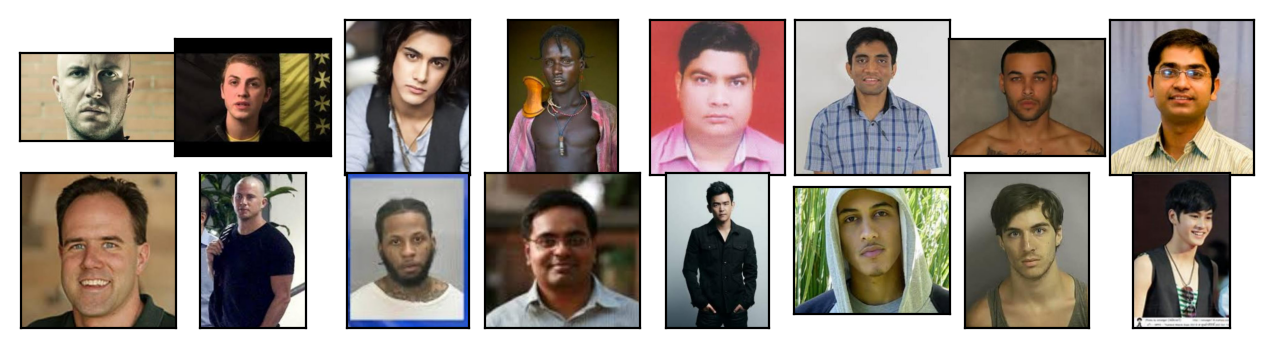

In [3]:
# Showing samples:
random.seed(42) # For reproducibility

imgs_men = os.listdir(pathMen) # Los of men images
imgs_women = os.listdir(pathWomen) # List of women images
imgs_baby = os.listdir(pathBaby) # List of baby images

# Creating random samples per category:
n_samples = 16

samples_men = random.sample(imgs_men, n_samples) # Randomly sample 16 images from men
samples_woman = random.sample(imgs_women, n_samples) # Ramdomly sample 16 imges from women
samples_baby = random.sample(imgs_baby, n_samples) # Randomply sample 16 images from baby

fig = plt.figure(dpi=200, figsize=(8, 2)) # Create a figure

# Showing the 16 images from men
for i in range(n_samples):
    ax = plt.subplot(2, 8, i+1) # Create a subplot
    img = Image.open(f"{pathMen}/{samples_men[i]}") # Open the image
    plt.imshow(img) # Show the image
    plt.xticks([]) # Remove x ticks
    plt.yticks([]) # Remove y ticks
    
plt.subplots_adjust(wspace=-0.01, hspace=-0.01) # Adjust the spacing
plt.show()

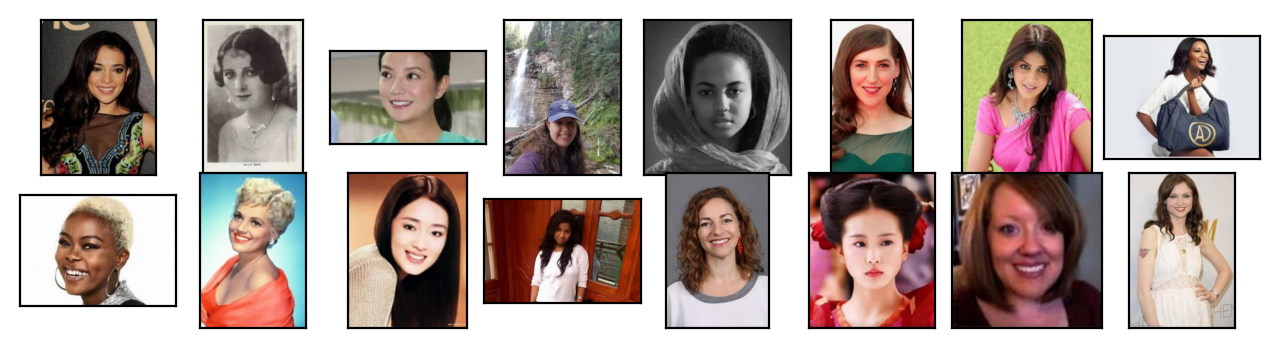

In [4]:
# Showing women samples:
fig = plt.figure(dpi=200, figsize=(8, 2)) # Create a figure

for i in range(n_samples):
    ax = plt.subplot(2, 8, i+1)
    img = Image.open(f"{pathWomen}/{samples_woman[i]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(wspace=-0.01, hspace=-0.01)
plt.show()

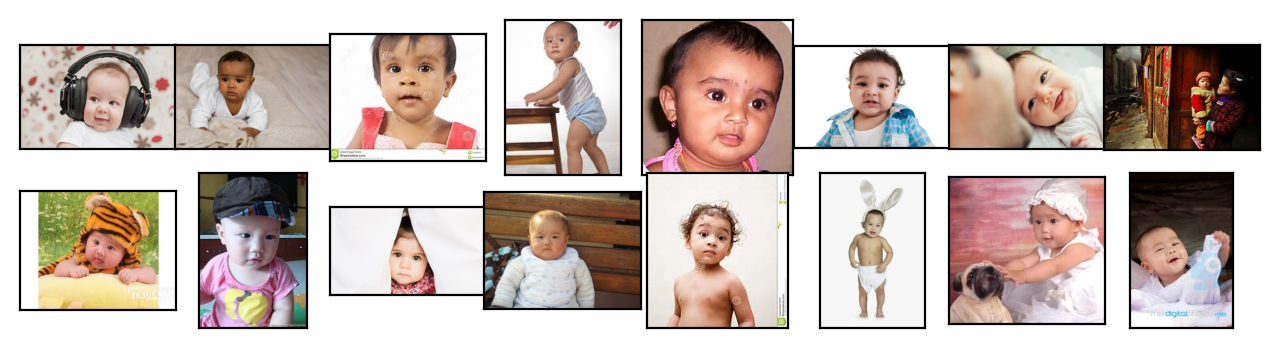

In [5]:
# Showing baby samples:
fig = plt.figure(dpi=200, figsize=(8, 2)) # Create a figure

for i in range(n_samples):
    ax = plt.subplot(2, 8, i+1)
    img = Image.open(f"{pathBaby}/{samples_baby[i]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(wspace=-0.01, hspace=-0.01)
plt.show()

# Defining the VAE architecture:

In [6]:
# Detecting if a GPU is available:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used: {torch.cuda.get_device_name(0)}") if device == "cuda" else print("No GPU available: Using CPU")

Device used: NVIDIA GeForce RTX 5080


In [7]:
# Transforming the data and creating batches for training:
transform = T.Compose([T.Resize((256, 256)), T.ToTensor()]) # Transforming the data into tensors of 256x256 with normalized pixels [0.0 - 1.0]
data = torchvision.datasets.ImageFolder(root=targetPath, transform=transform)
batch_size = 16

class_map = data.class_to_idx # Maping the the classes of data
targets = torch.tensor(data.targets) # Get the list of all the labels

# Filtering the class 'men'
men_idx = class_map['men']
men_indexes = torch.where(targets == men_idx)[0]
men_dataset = torch.utils.data.Subset(data, men_indexes)

men_loader = torch.utils.data.DataLoader(men_dataset, batch_size=batch_size, shuffle=True)

#loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [8]:
# Defining the architecture for the VAE:
latent_dims = 100 # Size of latent space

class Encoder(NN.Module):
    def __init__(self, latent_dims=latent_dims):
        super().__init__()
        # ###########################################
        # ############# Architecture 1: #############
        # ###########################################

        # self.conv1 = NN.Conv2d(3, 8, 3, stride=2, padding=1) # Input: 3x256x256 -> Output: 8x128x128
        # self.conv2 = NN.Conv2d(8, 16, 3, stride=2, padding=1) # Input: 8x128,128 -> Output: 16x64x64
        # self.batch2 = NN.BatchNorm2d(16) # Batch normalization layer
        # self.conv3 = NN.Conv2d(16, 32, 3, stride=2, padding=0) # Input: 16x64x64 -> Output: 32x31x31
        # self.linear = NN.Linear(31*31*32, 1024) # Fully connected layer

        # ###########################################


        # ###########################################
        # ############# Architecture 2: #############
        # ###########################################

        self.conv1 = NN.Conv2d(3, 32, 3, stride=2, padding=1) # Input: 3x256x256 -> Output: 32x128x128
        self.conv2 = NN.Conv2d(32, 64, 3, stride=2, padding=1) # Input: 32x128,128 -> Output: 64x64x64
        self.batch2 = NN.BatchNorm2d(64) # Batch normalization layer
        self.conv3 = NN.Conv2d(64, 128, 3, stride=2, padding=0) # Input: 64x64x64 -> Output: 128x31x31
        self.linear = NN.Linear(31*31*128, 1024) # Fully connected layer

        # ###########################################


        self.linear_mu = NN.Linear(1024, latent_dims) # Fully connected layer for mean
        self.linear_log_var = NN.Linear(1024, latent_dims) # Fully connected layer for log variance

        self.N = torch.distributions.Normal(0, 1) # Stardard normal distribution
        self.N.loc = self.N.loc.cuda() # Move to GPU if available
        self.N.scale.cuda() # Move to GPU id available

    def forward(self, x):
        x = x.to(device) # Move input to GPU or CPU
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear(x))

        mu = self.linear_mu(x) # Compute mean
        log_var = self.linear_log_var(x) # Compute log variance

        return mu, log_var
    
class Decoder(NN.Module):
    def __init__(self, latent_dims=latent_dims):
        super().__init__()
        # ###########################################
        # ############# Architecture 1: #############
        # ###########################################

        # self.decoder_lin = NN.Sequential(
        #     NN.Linear(latent_dims, 1024),
        #     NN.ReLU(True),
        #     NN.Linear(1024, 31*31*32),
        #     NN.ReLU(True)
        # )

        # self.unflatten = NN.Unflatten(dim=1, unflattened_size=(32, 31, 31))
        # self.decoder_conv = NN.Sequential(
        #     NN.ConvTranspose2d(32, 16, 3, stride=2, padding=0, output_padding=1),
        #     NN.BatchNorm2d(16),
        #     NN.ReLU(True),
        #     NN.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
        #     NN.BatchNorm2d(8),
        #     NN.ReLU(True),
        #     NN.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1)
        # )

        ###########################################


        # ###########################################
        # ############# Architecture 2: #############
        # ###########################################

        self.decoder_lin = NN.Sequential(
            NN.Linear(latent_dims, 1024),
            NN.ReLU(True),
            NN.Linear(1024, 31*31*128),
            NN.ReLU(True)
        )

        self.unflatten = NN.Unflatten(dim=1, unflattened_size=(128, 31, 31))
        self.decoder_conv = NN.Sequential(
            NN.ConvTranspose2d(128, 64, 3, stride=2, padding=0, output_padding=1),
            NN.BatchNorm2d(64),
            NN.ReLU(True),
            NN.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            NN.BatchNorm2d(32),
            NN.ReLU(True),
            NN.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1)
        )

        ###########################################


    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x) # Ensure an output in [0 - 1]

        return x
    
class VAE(NN.Module):
    def __init__(self, latent_dims=latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var) # Compute standard deviation from log variance
        eps = torch.rand_like(std) # Sample form standard normal distribution

        return mu + eps * std
    
    def forward(self, x):
        x = x.to(device)
        mu, log_var = self.encoder(x)
        z = self.reparametrize(mu, log_var)

        return self.decoder(z), mu, log_var

In [9]:
# Initialize VAE model and move it to the device
vae = VAE().to(device)
lr = 1e-4 # Learning rate
optimizer = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-6) # Adam Optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    patience=3,
)
kl_threshold = 2.0

In [10]:
# Define train epoch function:
# def train_epoch(epoch, beta):
#     vae.train()
#     epoch_loss = 0 # Accumulate the loss over the epoch

#     for imgs, _ in men_loader:
#         imgs = imgs.to(device)
#         recon_imgs, mu, log_var = vae(imgs)

#         #reconstruction_loss = F.mse_loss(recon_imgs, imgs, reduction='sum') # Mean Squared Error loss
        
#         # Experiment: Change MSE for Binary Cross Entropy using 'mean' instead of 'sum':
#         reconstruction_loss = F.binary_cross_entropy(recon_imgs, imgs, reduction='mean') # Binary Cross Entropy Error loss
        
#         #kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # KL Divergence
        
#         # Experiment: Change 'sum' for 'mean':
#         kl_div = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp()) # KL Divergence

#         # Experiment: Modifying the strength of KL regularization using beta:
#         loss = reconstruction_loss + beta * kl_div  # Total loss
#         optimizer.zero_grad()
#         loss.backward()

#         # Experiment: Cutting the gradient values to avoid INF or NaN:
#         NN.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)

#         optimizer.step()
#         epoch_loss += loss.item()

#     print(f"At epoch {epoch}, loss is {epoch_loss}")

def train_epoch(epoch, beta, kl_threshold): # Ahora recibe el threshold
    vae.train()
    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0 

    for imgs, _ in men_loader:
        imgs = imgs.to(device)

        recon_imgs, mu, log_var = vae(imgs)
        
        reconstruction_loss = F.mse_loss(recon_imgs, imgs, reduction='mean') # Mean Squared Error loss
        #reconstruction_loss = F.binary_cross_entropy(recon_imgs, imgs, reduction='mean')
        kl_div = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

        kl_penality = F.relu(kl_div - kl_threshold)

        loss = reconstruction_loss + beta * kl_penality
        optimizer.zero_grad()
        loss.backward() 
        NN.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        optimizer.step()

        #Acumulators:
        total_loss += loss.item() * imgs.size(0)
        total_recon_loss += reconstruction_loss.item() * imgs.size(0)
        total_kl_loss += kl_div.item() * imgs.size(0)


    avg_loss = total_loss / len(men_loader.dataset)
    avg_recon = total_recon_loss / len(men_loader.dataset)
    avg_kl = total_kl_loss / len(men_loader.dataset)

    print(f"Epoch {epoch} | Avg Loss: {avg_loss:.4f} | Recon Loss: {avg_recon:.4f} | KL Div: {avg_kl:.4f} | Beta: {beta:.4f}")

    return avg_loss

# Define plot function for reconstructions:
def plot_epoch():
    vae.eval()
    with torch.no_grad():
        noise = torch.randn(18, latent_dims).to(device) # Generate random noise in latent space
        imgs = vae.decoder(noise).cpu() # Decode the noise to generate images and move to CPU
        imgs = torchvision.utils.make_grid(imgs, 6, 3).numpy() # Arrange images in a grid

        fig, ax = plt.subplots(figsize=(6,3), dpi=100)
        plt.imshow(np.transpose(imgs, (1, 2, 0)))
        plt.axis("off")
        plt.show()

Epoch 0 | Avg Loss: 0.0658 | Recon Loss: 0.0658 | KL Div: 914238898153496641536.0000 | Beta: 0.0000


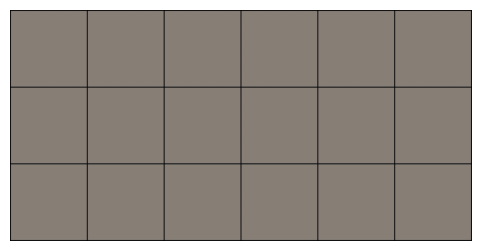

Epoch 1 | Avg Loss: 0.0348 | Recon Loss: 0.0346 | KL Div: 1.3036 | Beta: 0.0200
Epoch 2 | Avg Loss: 0.0293 | Recon Loss: 0.0293 | KL Div: 1.2838 | Beta: 0.0400
Epoch 3 | Avg Loss: 0.0257 | Recon Loss: 0.0257 | KL Div: 1.3165 | Beta: 0.0600
Epoch 4 | Avg Loss: 0.0233 | Recon Loss: 0.0232 | KL Div: 1.3180 | Beta: 0.0800
Epoch 5 | Avg Loss: 0.0215 | Recon Loss: 0.0215 | KL Div: 1.3632 | Beta: 0.1000
Epoch 6 | Avg Loss: 0.0204 | Recon Loss: 0.0204 | KL Div: 1.3774 | Beta: 0.1200
Epoch 7 | Avg Loss: 0.0194 | Recon Loss: 0.0194 | KL Div: 1.3981 | Beta: 0.1400
Epoch 8 | Avg Loss: 0.0185 | Recon Loss: 0.0185 | KL Div: 1.3515 | Beta: 0.1600
Epoch 9 | Avg Loss: 0.0174 | Recon Loss: 0.0174 | KL Div: 1.3707 | Beta: 0.1800
Epoch 10 | Avg Loss: 0.0166 | Recon Loss: 0.0165 | KL Div: 1.3791 | Beta: 0.2000


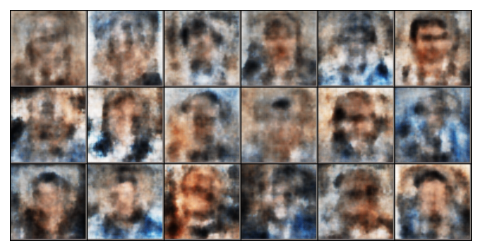

Epoch 11 | Avg Loss: 0.0159 | Recon Loss: 0.0159 | KL Div: 1.4336 | Beta: 0.2200
Epoch 12 | Avg Loss: 0.0152 | Recon Loss: 0.0152 | KL Div: 1.3386 | Beta: 0.2400
Epoch 13 | Avg Loss: 0.0144 | Recon Loss: 0.0143 | KL Div: 1.4199 | Beta: 0.2600
Epoch 14 | Avg Loss: 0.0137 | Recon Loss: 0.0137 | KL Div: 1.4454 | Beta: 0.2800
Epoch 15 | Avg Loss: 0.0131 | Recon Loss: 0.0131 | KL Div: 1.4075 | Beta: 0.3000
Epoch 16 | Avg Loss: 0.0126 | Recon Loss: 0.0125 | KL Div: 1.4740 | Beta: 0.3200
Epoch 17 | Avg Loss: 0.0120 | Recon Loss: 0.0120 | KL Div: 1.4929 | Beta: 0.3400
Epoch 18 | Avg Loss: 0.0116 | Recon Loss: 0.0115 | KL Div: 1.3957 | Beta: 0.3600
Epoch 19 | Avg Loss: 0.0111 | Recon Loss: 0.0111 | KL Div: 1.4456 | Beta: 0.3800
Epoch 20 | Avg Loss: 0.0107 | Recon Loss: 0.0107 | KL Div: 1.4808 | Beta: 0.4000


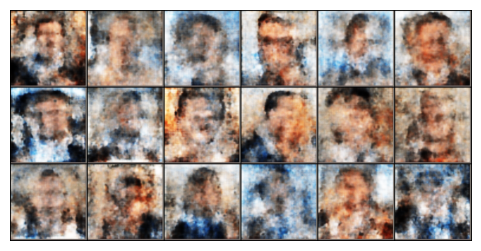

Epoch 21 | Avg Loss: 0.0108 | Recon Loss: 0.0106 | KL Div: 1.4669 | Beta: 0.4200
Epoch 22 | Avg Loss: 0.0103 | Recon Loss: 0.0103 | KL Div: 1.3900 | Beta: 0.4400
Epoch 23 | Avg Loss: 0.0100 | Recon Loss: 0.0099 | KL Div: 1.4517 | Beta: 0.4600
Epoch 24 | Avg Loss: 0.0098 | Recon Loss: 0.0098 | KL Div: 1.4320 | Beta: 0.4800
Epoch 25 | Avg Loss: 0.0097 | Recon Loss: 0.0097 | KL Div: 1.4684 | Beta: 0.5000
Epoch 26 | Avg Loss: 0.0095 | Recon Loss: 0.0095 | KL Div: 1.4733 | Beta: 0.5200
Epoch 27 | Avg Loss: 0.0094 | Recon Loss: 0.0093 | KL Div: 1.4653 | Beta: 0.5400
Epoch 28 | Avg Loss: 0.0093 | Recon Loss: 0.0093 | KL Div: 1.4756 | Beta: 0.5600
Epoch 29 | Avg Loss: 0.0090 | Recon Loss: 0.0090 | KL Div: 1.4731 | Beta: 0.5800
Epoch 30 | Avg Loss: 0.0090 | Recon Loss: 0.0089 | KL Div: 1.4758 | Beta: 0.6000


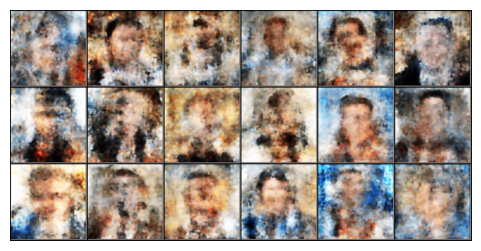

Epoch 31 | Avg Loss: 0.0090 | Recon Loss: 0.0088 | KL Div: 1.4526 | Beta: 0.6200
Epoch 32 | Avg Loss: 0.0089 | Recon Loss: 0.0088 | KL Div: 1.4857 | Beta: 0.6400
Epoch 33 | Avg Loss: 0.0088 | Recon Loss: 0.0087 | KL Div: 1.4668 | Beta: 0.6600
Epoch 34 | Avg Loss: 0.0087 | Recon Loss: 0.0086 | KL Div: 1.5142 | Beta: 0.6800
Epoch 35 | Avg Loss: 0.0086 | Recon Loss: 0.0085 | KL Div: 1.5305 | Beta: 0.7000
Epoch 36 | Avg Loss: 0.0084 | Recon Loss: 0.0084 | KL Div: 1.4536 | Beta: 0.7200
Epoch 37 | Avg Loss: 0.0084 | Recon Loss: 0.0084 | KL Div: 1.4483 | Beta: 0.7400
Epoch 38 | Avg Loss: 0.0084 | Recon Loss: 0.0083 | KL Div: 1.4642 | Beta: 0.7600
Epoch 39 | Avg Loss: 0.0085 | Recon Loss: 0.0083 | KL Div: 1.5952 | Beta: 0.7800
Epoch 40 | Avg Loss: 0.0082 | Recon Loss: 0.0082 | KL Div: 1.4388 | Beta: 0.8000


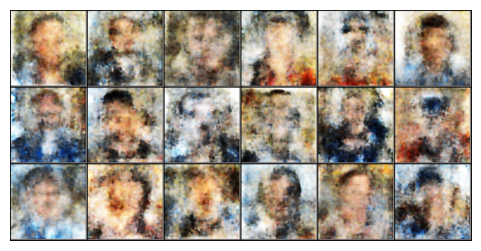

Epoch 41 | Avg Loss: 0.0082 | Recon Loss: 0.0080 | KL Div: 1.4517 | Beta: 0.8200
Epoch 42 | Avg Loss: 0.0079 | Recon Loss: 0.0079 | KL Div: 1.4923 | Beta: 0.8400
Epoch 43 | Avg Loss: 0.0078 | Recon Loss: 0.0078 | KL Div: 1.5475 | Beta: 0.8600
Epoch 44 | Avg Loss: 0.0079 | Recon Loss: 0.0079 | KL Div: 1.4319 | Beta: 0.8800
Epoch 45 | Avg Loss: 0.0080 | Recon Loss: 0.0079 | KL Div: 1.4776 | Beta: 0.9000
Epoch 46 | Avg Loss: 0.0077 | Recon Loss: 0.0077 | KL Div: 1.5502 | Beta: 0.9200
Epoch 47 | Avg Loss: 0.0080 | Recon Loss: 0.0078 | KL Div: 1.4050 | Beta: 0.9400
Epoch 48 | Avg Loss: 0.0080 | Recon Loss: 0.0078 | KL Div: 1.4770 | Beta: 0.9600
Epoch 49 | Avg Loss: 0.0076 | Recon Loss: 0.0076 | KL Div: 1.5158 | Beta: 0.9800
Epoch 50 | Avg Loss: 0.0078 | Recon Loss: 0.0076 | KL Div: 1.4501 | Beta: 1.0000


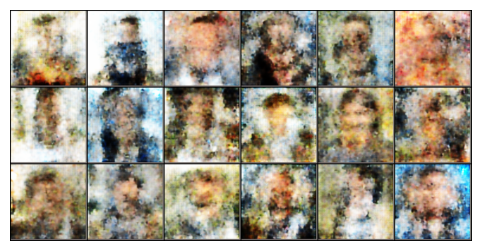

Epoch 51 | Avg Loss: 0.0076 | Recon Loss: 0.0076 | KL Div: 1.5475 | Beta: 1.0000
Epoch 52 | Avg Loss: 0.0076 | Recon Loss: 0.0075 | KL Div: 1.4458 | Beta: 1.0000
Epoch 53 | Avg Loss: 0.0075 | Recon Loss: 0.0074 | KL Div: 1.5603 | Beta: 1.0000
Epoch 54 | Avg Loss: 0.0077 | Recon Loss: 0.0075 | KL Div: 1.4018 | Beta: 1.0000
Epoch 55 | Avg Loss: 0.0076 | Recon Loss: 0.0075 | KL Div: 1.4872 | Beta: 1.0000
Epoch 56 | Avg Loss: 0.0075 | Recon Loss: 0.0075 | KL Div: 1.4511 | Beta: 1.0000
Epoch 57 | Avg Loss: 0.0076 | Recon Loss: 0.0074 | KL Div: 1.4888 | Beta: 1.0000
Epoch 58 | Avg Loss: 0.0069 | Recon Loss: 0.0069 | KL Div: 1.1776 | Beta: 1.0000
Epoch 59 | Avg Loss: 0.0063 | Recon Loss: 0.0063 | KL Div: 1.4067 | Beta: 1.0000
Epoch 60 | Avg Loss: 0.0060 | Recon Loss: 0.0060 | KL Div: 1.5955 | Beta: 1.0000


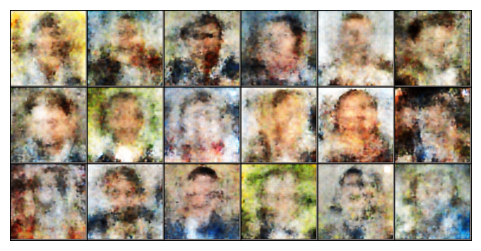

Epoch 61 | Avg Loss: 0.0059 | Recon Loss: 0.0059 | KL Div: 1.7535 | Beta: 1.0000
Epoch 62 | Avg Loss: 0.0058 | Recon Loss: 0.0058 | KL Div: 1.7720 | Beta: 1.0000
Epoch 63 | Avg Loss: 0.0057 | Recon Loss: 0.0057 | KL Div: 1.7966 | Beta: 1.0000
Epoch 64 | Avg Loss: 0.0057 | Recon Loss: 0.0056 | KL Div: 1.7490 | Beta: 1.0000
Epoch 65 | Avg Loss: 0.0056 | Recon Loss: 0.0055 | KL Div: 1.8511 | Beta: 1.0000
Epoch 66 | Avg Loss: 0.0055 | Recon Loss: 0.0055 | KL Div: 1.7321 | Beta: 1.0000
Epoch 67 | Avg Loss: 0.0055 | Recon Loss: 0.0054 | KL Div: 1.7707 | Beta: 1.0000
Epoch 68 | Avg Loss: 0.0054 | Recon Loss: 0.0054 | KL Div: 1.8069 | Beta: 1.0000
Epoch 69 | Avg Loss: 0.0055 | Recon Loss: 0.0054 | KL Div: 1.7162 | Beta: 1.0000
Epoch 70 | Avg Loss: 0.0053 | Recon Loss: 0.0053 | KL Div: 1.7818 | Beta: 1.0000


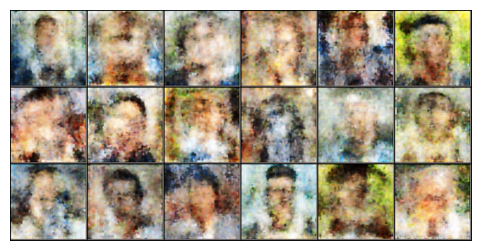

Epoch 71 | Avg Loss: 0.0053 | Recon Loss: 0.0053 | KL Div: 1.7959 | Beta: 1.0000
Epoch 72 | Avg Loss: 0.0053 | Recon Loss: 0.0053 | KL Div: 1.7509 | Beta: 1.0000
Epoch 73 | Avg Loss: 0.0053 | Recon Loss: 0.0053 | KL Div: 1.8500 | Beta: 1.0000
Epoch 74 | Avg Loss: 0.0052 | Recon Loss: 0.0052 | KL Div: 1.7554 | Beta: 1.0000
Epoch 75 | Avg Loss: 0.0054 | Recon Loss: 0.0052 | KL Div: 1.7898 | Beta: 1.0000
Epoch 76 | Avg Loss: 0.0052 | Recon Loss: 0.0052 | KL Div: 1.8202 | Beta: 1.0000
Epoch 77 | Avg Loss: 0.0052 | Recon Loss: 0.0052 | KL Div: 1.7530 | Beta: 1.0000
Epoch 78 | Avg Loss: 0.0052 | Recon Loss: 0.0052 | KL Div: 1.7667 | Beta: 1.0000
Epoch 79 | Avg Loss: 0.0051 | Recon Loss: 0.0051 | KL Div: 1.8481 | Beta: 1.0000
Epoch 80 | Avg Loss: 0.0051 | Recon Loss: 0.0051 | KL Div: 1.7366 | Beta: 1.0000


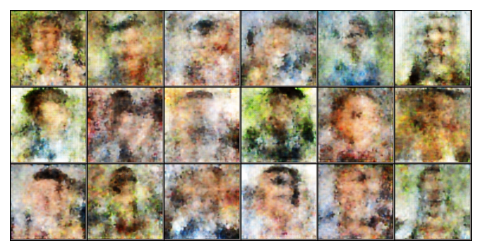

Epoch 81 | Avg Loss: 0.0052 | Recon Loss: 0.0051 | KL Div: 1.7833 | Beta: 1.0000
Epoch 82 | Avg Loss: 0.0051 | Recon Loss: 0.0051 | KL Div: 1.8127 | Beta: 1.0000
Epoch 83 | Avg Loss: 0.0051 | Recon Loss: 0.0051 | KL Div: 1.7515 | Beta: 1.0000
Epoch 84 | Avg Loss: 0.0051 | Recon Loss: 0.0050 | KL Div: 1.7213 | Beta: 1.0000
Epoch 85 | Avg Loss: 0.0051 | Recon Loss: 0.0050 | KL Div: 1.8594 | Beta: 1.0000
Epoch 86 | Avg Loss: 0.0050 | Recon Loss: 0.0050 | KL Div: 1.7692 | Beta: 1.0000
Epoch 87 | Avg Loss: 0.0051 | Recon Loss: 0.0050 | KL Div: 1.7495 | Beta: 1.0000
Epoch 88 | Avg Loss: 0.0050 | Recon Loss: 0.0050 | KL Div: 1.8333 | Beta: 1.0000
Epoch 89 | Avg Loss: 0.0050 | Recon Loss: 0.0050 | KL Div: 1.7830 | Beta: 1.0000
Epoch 90 | Avg Loss: 0.0050 | Recon Loss: 0.0050 | KL Div: 1.7454 | Beta: 1.0000


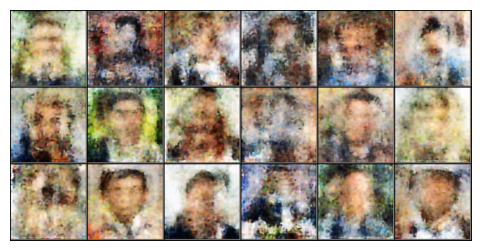

Epoch 91 | Avg Loss: 0.0051 | Recon Loss: 0.0050 | KL Div: 1.7869 | Beta: 1.0000
Epoch 92 | Avg Loss: 0.0049 | Recon Loss: 0.0049 | KL Div: 1.8097 | Beta: 1.0000
Epoch 93 | Avg Loss: 0.0050 | Recon Loss: 0.0050 | KL Div: 1.7712 | Beta: 1.0000
Epoch 94 | Avg Loss: 0.0050 | Recon Loss: 0.0050 | KL Div: 1.7505 | Beta: 1.0000
Epoch 95 | Avg Loss: 0.0049 | Recon Loss: 0.0049 | KL Div: 1.8339 | Beta: 1.0000
Epoch 96 | Avg Loss: 0.0049 | Recon Loss: 0.0049 | KL Div: 1.7685 | Beta: 1.0000
Epoch 97 | Avg Loss: 0.0051 | Recon Loss: 0.0049 | KL Div: 1.7792 | Beta: 1.0000
Epoch 98 | Avg Loss: 0.0049 | Recon Loss: 0.0049 | KL Div: 1.8435 | Beta: 1.0000
Epoch 99 | Avg Loss: 0.0049 | Recon Loss: 0.0049 | KL Div: 1.7786 | Beta: 1.0000


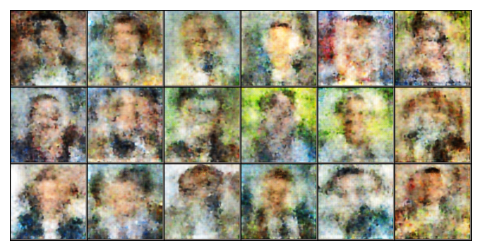

In [11]:
# ==========================================================================
# ####### MODEL TRAINING (EXCECUTE ONLY IF RE-TRAINING IS NECESSARY) #######
# ==========================================================================

n_epochs = 100
max_beta = 1.0
warmup_epochs = 50

for epoch in range(n_epochs):

    beta = max_beta * min(1.0, (epoch / warmup_epochs)) # Strength of KL regularization

    avg_loss = train_epoch(epoch, beta, kl_threshold)

    if epoch % 10 == 0 or epoch == n_epochs - 1:
            # Llama a tu función de ploteo
            plot_epoch()

    scheduler.step(avg_loss)

# Saving the trained model:
torch.save(vae.state_dict(), "../models/vae_UTKFace.pth")

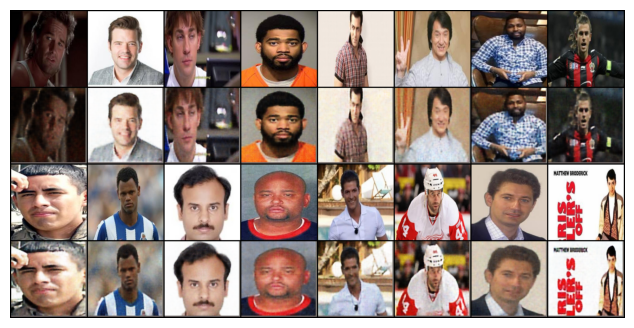

In [12]:
# Generating images using the trained model:
vae.eval()

with torch.no_grad():
    vae.load_state_dict(torch.load("../models/vae_UTKFace.pth", map_location=device))
    imgs, _ = next(iter(men_loader)) # Get a batch of images
    imgs = imgs.to(device)
    recon_imgs, mu, log_var = vae(imgs) # Forward pass through VAE

    # Concatenate the original and reconstructed images:
    images = torch.cat([
        imgs[:8].detach().cpu(),
        recon_imgs[:8].detach().cpu(),
        imgs[8:16].detach().cpu(),
        recon_imgs[8:16].detach().cpu()
    ], dim=0)

    images = torchvision.utils.make_grid(images, 8, 4)
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    plt.imshow(np.transpose(images.numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Encoding Arithmetic with VAE